<a href="https://colab.research.google.com/github/DM-ILLER/ViT-Paper-Replication/blob/main/08_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. Milestone Project 2: PyTorch Paper Replicating

The goal of machine learning research paper replicating is: turn a ML research paper into useable code.

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture/paper with PyTorch

## 0. Get Setup

Let's import code we've previously written + required libraries.

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.0+cu116
torchvision version: 0.14.0+cu116


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3297, done.
remote: Counting objects: 100% (277/277), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 3297 (delta 137), reused 230 (delta 110), pack-reused 3020
Receiving objects: 100% (3297/3297), 642.58 MiB | 36.72 MiB/s, done.
Resolving deltas: 100% (1867/1867), done.
Checking out files: 100% (221/221), done.


In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

The whole goal fo what we're trying to do is to replicate ViT architecture for our FoodVision Mini problem.

To do that, we need some data.

Namely, the pizza, steak, and sushi images we've been using so far.

In [ ]:
# Download pizza, steak, and sushi data
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [ ]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create image size
IMG_SIZE = 224 # Comes from Table 3 of the ViT paper

# Create transform pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f"Manually-created transforms: {manual_transforms}")

Manually-created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [ ]:
# Create a batch size of 32 (the paper uses 4096, but this may be too big for our smaller hardware, can always scale up later)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

As always, let's adhere to the motto, *visualize, visualize, visualize!*

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label
image, label = image_batch[0], label_batch[0]

# View the sinlge image and label shapes
image.shape, label.shape

(torch.Size([3, 224, 224]), torch.Size([]))

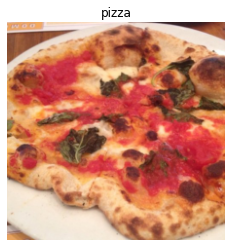

In [ ]:
# Plot the image 
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0)) # [height, width, color channels]
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating ViT Overview

Looking at a whole machine learning research paper can be intimidating.

So in order to make it more understandable, we can break it down into smaller pieces.

* **Inputs** - What goes into the model? (In our case, batches of image tensors)
* **Outputs** - What comes out of the model? (In our case, image classification labels)
* **Layers** - Takes an input, manipulates it with a function (e.g. self-attention).
* **Blocks** - A collection of layers.
* **Model (or architecture)** - A collection of blocks and a classifier head.


### 3.1 ViT overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block.
* Table 1/3: Different hyperparameters for the architecture/training.
* Text descriptions (especially 3.1)

### Figure 1

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png)

* Embedding = learnable representation (start with random numbers and improve over time)

### Four Equations
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png)

#### In pseudocode:
**Equation 1:**
```python
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```
* Input image shape: $H\times{W}\times{C}$ [height, width, color channels]
* Output image shape: ${N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = image resolution ($H\times{W}$) / patch resolution ($P^2$)

**Equation 2&3:**
```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

**Equation 4:**
* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time
```python
y = Linear_layer(LN_layer(x_output_MLP_block))
```

### Table 1
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png)

* ViT-Base, ViT-Large, and ViT-Huge are all different sizes of the same model architecture
* ViTB/16 - ViT-Base with image patch size of 16x16
* Layers - the number of transformer encoder blocks
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - the number of hidden units/neurons in the MLP
* Heads - is the number of multi-head self-attention

## 4. Equation 1: Split data into patches and creating the class position and patch embedding 

Layers = input -> function -> output

What's the input shape?

What's the output shape?

* Input shape: (224, 224, 3) -> single image -> (height, width, color channels)
* Output shape: ???

### 4.1 Calculating input and output shapes by hand

In [ ]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) // patch_size **2)
number_of_patches

196

In [ ]:
# Input shape 
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape} ")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3) 
Output shape (single 1D sequence of patches): (196, 768)


### 4.2 Turning a single image into patches

Let's visualize, visualize, visualize!

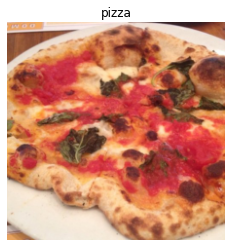

In [ ]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [ ]:
image.shape

torch.Size([3, 224, 224])

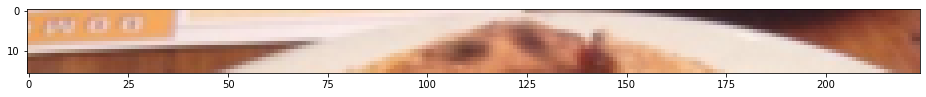

In [ ]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # convert image to color channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16

plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


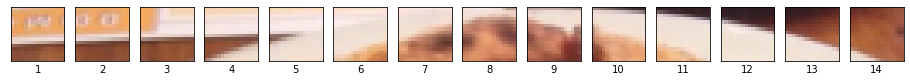

In [ ]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column per patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size,:])
  axs[i].set_xlabel(i+1) # set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14      
Number of patches per column: 14      
Total patches: 196      
Patch size: 16 pixels x 16 pixels


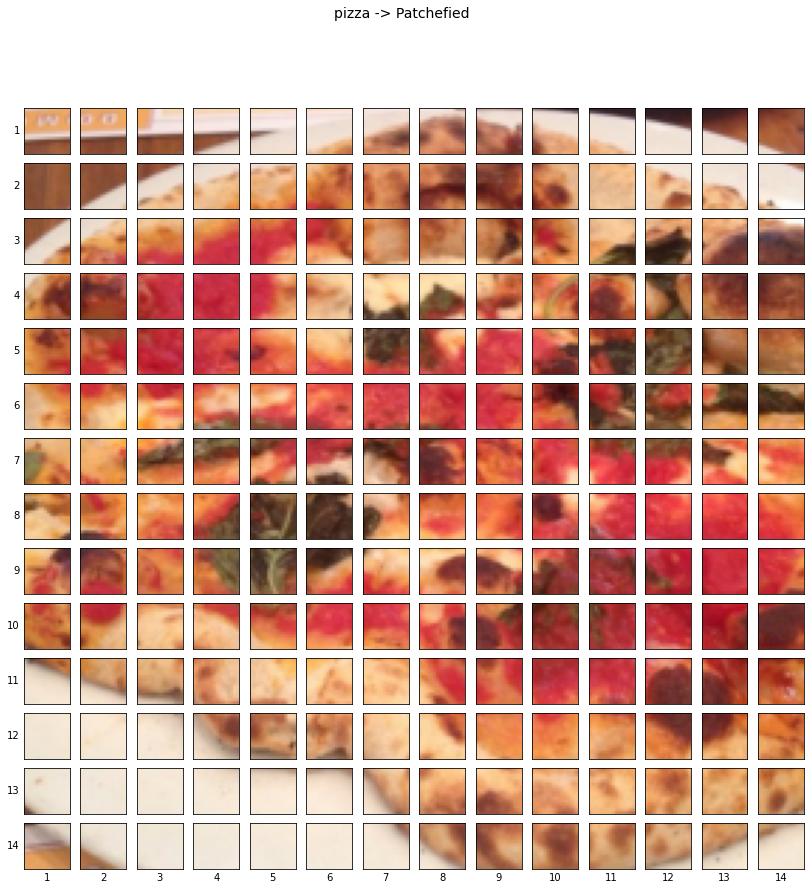

In [ ]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size // patch_size
assert img_size % patch_size == 0, "Image size must be devisible by patch size"
print(f"Number of patches per row: {num_patches}\
      \nNumber of patches per column: {num_patches}\
      \nTotal patches: {num_patches**2}\
      \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=num_patches,
                        ncols=num_patches,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of the image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    # Plot the permuted image on the different axs
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through the height
                                     patch_width:patch_width+patch_size, # iterate throught the width
                                     :]) # get all of the color channels
    # Setup label information for each subplot
    axs[i, j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Set title for plot 
fig.suptitle(f"{class_names[label]} -> Patchefied", fontsize=14)
plt.show();

### 4.3 Creating image patches and turnign them into patch embeddings

Perhaps we could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`.

In [ ]:
# Create Conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch_size
patch_size = 16

# Create Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # for color images
                   out_channels=768, # D size from table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

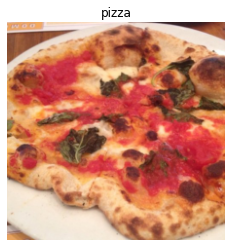

In [ ]:
# View a single image
plt.imshow(image_permuted)
plt.title(class_names[label])
plt.axis(False);

In [ ]:
# Pass the image through the convoloutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a batch dimension [batch_size, color_channels, height, width]
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we've passed a single image to our `conv2d` layer, it's shape is:

```python
torch.Size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_maph_height, feature_map_width]
```

Showing random convolutional feature maps from indexes: [263, 520, 723, 134, 675]


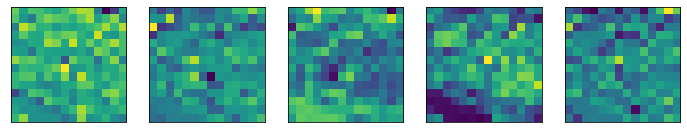

In [ ]:
# Plot random convolutional features maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create a plot
fig, axs = plt.subplots(nrows=1,
                        ncols=5,
                        figsize=(12, 12))
# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension and remove from grad tracking/switch to numpy from matplotlib
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[0.3945, 0.2850, 0.2579, 0.2064, 0.3724, 0.4050, 0.2293, 0.2832,
           0.2571, 0.4865, 0.4220, 0.3477, 0.3527, 0.4177],
          [0.2742, 0.3524, 0.4455, 0.3839, 0.4887, 0.4198, 0.3804, 0.2651,
           0.2498, 0.4515, 0.4472, 0.4855, 0.4677, 0.3775],
          [0.5735, 0.3430, 0.3763, 0.3509, 0.4229, 0.3379, 0.4352, 0.4697,
           0.3863, 0.5376, 0.2710, 0.1361, 0.1876, 0.0530],
          [0.2079, 0.2446, 0.2799, 0.2603, 0.3989, 0.4499, 0.3105, 0.2787,
           0.3070, 0.3825, 0.3820, 0.2602, 0.3387, 0.2754],
          [0.4061, 0.3472, 0.2921, 0.3011, 0.4146, 0.4641, 0.2926, 0.3707,
           0.3624, 0.1561, 0.1248, 0.1966, 0.2988, 0.3773],
          [0.4789, 0.4804, 0.4007, 0.3182, 0.2941, 0.3147, 0.3153, 0.2368,
           0.3278, 0.3484, 0.2278, 0.2578, 0.3303, 0.2816],
          [0.3994, 0.4399, 0.4024, 0.4556, 0.3778, 0.3205, 0.2982, 0.2798,
           0.4264, 0.3890, 0.3928, 0.4908, 0.5278, 0.4720],
          [0.4181, 0.3613, 0.4127, 0.2820, 0.1779, 0.08

### 4.4 Flattenning the patch embedding with `torch.nn.Flatten()`

Right now, we've got a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the criteria of the ViT Encoder.


In [ ]:
print(f'{image_out_of_conv.shape} -> [batch_size, embedding_dim, height, width]')

torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, height, width]


Want: (batch_size, num_patches, embedding_dim)

In [ ]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2, 
                           end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Orginal image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


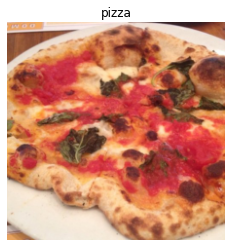

In [ ]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f'Orginal image shape: {image.shape}')

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [ ]:
# Rearrange output of flatten layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened.permute(0, 2, 1).shape} -> [batch_size, num_patches, embedding dimension]")

torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding dimension]


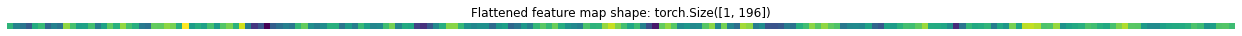

In [ ]:
# Get a sinlge flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:
1. Create a class called `PatchEmbedding` that inherist from `nn.Module`
2. Initialize with appropriate hyperparameters, such as channels, embeding dimension, patch size.
3. Create a layer to run an image into embedding patches using `nn.Conv2d()`.
4. Create a layer to flatten the feature maps of the output of the layer in 3
5. Define a `forward()` method that defines the forward computation
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [ ]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [ ]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single iamge through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add a batch dimension
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [ ]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

patchify(rand_image_tensor)

tensor([[[-0.3601,  0.2602, -0.7408,  ..., -1.2910, -0.2012, -0.0354],
         [-0.3405,  0.6132,  0.6626,  ..., -0.6314, -1.8604,  0.3311],
         [-0.0176, -0.2323, -0.1009,  ...,  0.1873,  0.6899, -0.5419],
         ...,
         [ 0.5333, -0.7641, -0.1217,  ...,  0.2381,  0.5565,  0.0466],
         [-0.6577, -0.0324, -0.6278,  ..., -0.1591,  0.7905,  1.4529],
         [-1.1716, -0.1617, -0.1427,  ...,  0.5600,  0.4640,  0.7539]]],
       grad_fn=<PermuteBackward0>)

### 4.6 Creating the class token embedding

Want to: prepend a learnable class token to the start of the patch embedding.

In [ ]:
patch_embedded_image

tensor([[[-0.8187,  0.1019, -0.0634,  ...,  0.2753, -0.3053,  0.2613],
         [-0.8136,  0.1848, -0.0687,  ...,  0.3158, -0.3876,  0.2131],
         [-0.9328,  0.2342,  0.0273,  ...,  0.4122, -0.5147,  0.1848],
         ...,
         [-0.7878,  0.2044, -0.1951,  ...,  0.4476, -0.2862,  0.2153],
         [-0.6559,  0.1897, -0.4146,  ...,  0.5879, -0.2773,  0.2240],
         [-0.9477,  0.2818, -0.3038,  ...,  0.6265, -0.2616,  0.3324]]],
       grad_fn=<PermuteBackward0>)

In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [ ]:
# Create class token embedding as a learnable parameter that share the same size as the embedding parameter
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [ ]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [ ]:
# Propend the class token embedding to the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1)

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, class_token + number_of_patches, embedding_dim]")


tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.8187,  0.1019, -0.0634,  ...,  0.2753, -0.3053,  0.2613],
         [-0.8136,  0.1848, -0.0687,  ...,  0.3158, -0.3876,  0.2131],
         ...,
         [-0.7878,  0.2044, -0.1951,  ...,  0.4476, -0.2862,  0.2153],
         [-0.6559,  0.1897, -0.4146,  ...,  0.5879, -0.2773,  0.2240],
         [-0.9477,  0.2818, -0.3038,  ...,  0.6265, -0.2616,  0.3324]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, class_token + number_of_patches, embedding_dim]


### 4.7 Creating the position embedding

Want to: create a series of 1D learnable position embeddingds and to add them to a sequence of patch embeddings

In [ ]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.8187,  0.1019, -0.0634,  ...,  0.2753, -0.3053,  0.2613],
          [-0.8136,  0.1848, -0.0687,  ...,  0.3158, -0.3876,  0.2131],
          ...,
          [-0.7878,  0.2044, -0.1951,  ...,  0.4476, -0.2862,  0.2153],
          [-0.6559,  0.1897, -0.4146,  ...,  0.5879, -0.2773,  0.2240],
          [-0.9477,  0.2818, -0.3038,  ...,  0.6265, -0.2616,  0.3324]]],
        grad_fn=<CatBackward0>), torch.Size([1, 197, 768]))

In [ ]:
# Calculate N (number_of_patches)
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [ ]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.1813, 1.1019, 0.9366,  ..., 1.2753, 0.6947, 1.2613],
         [0.1864, 1.1848, 0.9313,  ..., 1.3158, 0.6124, 1.2131],
         ...,
         [0.2122, 1.2044, 0.8049,  ..., 1.4476, 0.7138, 1.2153],
         [0.3441, 1.1897, 0.5854,  ..., 1.5879, 0.7227, 1.2240],
         [0.0523, 1.2818, 0.6962,  ..., 1.6265, 0.7384, 1.3324]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


### 4.8 Putting it all together: from image to embedding

We've written code to turn an image into a flattened sequence of patch embedddings.
Now let's see it all in one cell.

In [ ]:
# Set seeds
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shapes of the original image tensor and get the image dimension
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass input image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding),
                                        dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")


Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Equation 2: Multihead Self-Attention (MSA Block)

* Multihead self-attention: which part of a sequence should pay the most attention to itself>
  * In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
  * We watn out neural network (ViT) to learn this relationship/representation.
* To replicate MSA in PyTorch we can use `torch.nn.MulitheadAttention()`
* Layer normalization (LayerNorm) is a technique to normalize the distribution of intermediate layers. It enables smoother gradients, faster training, and better generalized accuraccy.
  * Normalization = make everything have the same mean and the same standard deviation
  * normalizes values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension.
  * When we normalize along the embedding dimension, it's like making all of the stairs in a staircase the same size. 

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """
  Creates a multihead self attention block ('MSA block' for short)
  """
  def __init__(self,
               embedding_dim:int = 768, # Hidden size D 
               num_heads:int = 12,
               attn_dropout:int = 0):
    super().__init__()
    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create multihead self-attension layer (MSA)
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True) # [batch, sequence, feature]
    
  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                         key=x,
                                         value=x,
                                         need_weights=False)
    return attn_output

In [ ]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)
# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [ ]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.1813, 1.1019, 0.9366,  ..., 1.2753, 0.6947, 1.2613],
         [0.1864, 1.1848, 0.9313,  ..., 1.3158, 0.6124, 1.2131],
         ...,
         [0.2122, 1.2044, 0.8049,  ..., 1.4476, 0.7138, 1.2153],
         [0.3441, 1.1897, 0.5854,  ..., 1.5879, 0.7227, 1.2240],
         [0.0523, 1.2818, 0.6962,  ..., 1.6265, 0.7384, 1.3324]]],
       grad_fn=<AddBackward0>)

In [ ]:
patched_image_through_msa_block

tensor([[[-0.2477, -0.3165,  0.0746,  ..., -0.4308,  0.9293, -0.4933],
         [-0.2458, -0.3119,  0.0745,  ..., -0.4298,  0.9420, -0.5083],
         [-0.2449, -0.3122,  0.0748,  ..., -0.4294,  0.9411, -0.5088],
         ...,
         [-0.2432, -0.3077,  0.0781,  ..., -0.4284,  0.9392, -0.5085],
         [-0.2444, -0.3057,  0.0777,  ..., -0.4283,  0.9393, -0.5086],
         [-0.2454, -0.3064,  0.0784,  ..., -0.4285,  0.9412, -0.5084]]],
       grad_fn=<TransposeBackward0>)

## 6. Equation 3: Multilayer Perceptron (MLP block)

* **MlP** = The MLP contains two layers with a GELU non-linearity 
  * MLP = a quite broad term for a block with a series of layer (s),  layers can be mutliple or even only one hidden layer.
  * Layers can mean: fully-connected, dense, linear, feed-forward, are all often similar names for the same thing. In PyTorch, they're often called `torch.nn.Linear()` and in Tensorflow they might be called `tf.keras.layers.Dense()`
  * Gelu in PyTorch - `torch.nn.GELU`
  * MLP number of hidden units = MLP size in table one
* **Dropout** = Dropout, when used is applied after everyd ense layer except for the qkv-projections and directly after adding positional- to patch embeddings.
  * Value for dropout is available in table three

In pseudocode:
```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```

In [ ]:
class MLPBlock(nn.Module):
  ''' The multilayer perceptron block of the ViT Transformer which contains two GELU non-linearities.'''
  def __init__(self,
               embedding_dim:int = 768,
               mlp_size:int = 3072,
               dropout:int = 0.1):
    super().__init__()

    # Creat the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)                     
    )
    
  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return (x)
    # return self.mlp(self.layer_norm(x)) benefits from operator fusion
    

In [ ]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass the output of the MSABlock through the MSABlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


In [ ]:
patched_image_through_msa_block

tensor([[[-0.2477, -0.3165,  0.0746,  ..., -0.4308,  0.9293, -0.4933],
         [-0.2458, -0.3119,  0.0745,  ..., -0.4298,  0.9420, -0.5083],
         [-0.2449, -0.3122,  0.0748,  ..., -0.4294,  0.9411, -0.5088],
         ...,
         [-0.2432, -0.3077,  0.0781,  ..., -0.4284,  0.9392, -0.5085],
         [-0.2444, -0.3057,  0.0777,  ..., -0.4283,  0.9393, -0.5086],
         [-0.2454, -0.3064,  0.0784,  ..., -0.4285,  0.9412, -0.5084]]],
       grad_fn=<TransposeBackward0>)

In [ ]:
patched_image_through_mlp_block

tensor([[[-0.0645, -0.0099,  0.2135,  ..., -0.0000, -0.1862,  0.1956],
         [-0.1385, -0.1457,  0.3057,  ..., -0.1479, -0.1603,  0.1896],
         [-0.0326, -0.0410,  0.3322,  ..., -0.0000, -0.2228,  0.1983],
         ...,
         [-0.2034, -0.0389,  0.3012,  ...,  0.0687, -0.2474,  0.2835],
         [-0.1492,  0.0302,  0.0000,  ...,  0.0132, -0.2048,  0.0845],
         [-0.1101, -0.0343,  0.2705,  ..., -0.1600, -0.1785,  0.1809]]],
       grad_fn=<MulBackward0>)

## 7. Creating the Transformer Encoder

The Transformer Encoder is a combination of alternating blocks of MSA (equation two) and MLP (equation three).

And there are residual connections between each block.

* Encoder = turn a sequence into learnable representation
* Decoder = go from learned representation back to some sort of sequence
* Residual connectiosn = add a layer(s) input to its subsequent output
  * enables the creation of deeper networks
  * prevents weight from getting too small

In pseudocode:

```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -. MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

### 7.1 Create a custom Transforer Encoder block

In [ ]:
class TransformerEncoderBlock(nn.Module):
  ''' Combination of alternating blocks of MSA and MLP blocks'''
  def __init__(self,
               embedding_dim:int = 768,
               num_heads:int = 12,
               attn_dropout:int = 0,
               mlp_size:int = 3072,
               dropout:float =0.1):
    super().__init__()

    # Create MSA block (equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)
    # Create MLP block (equation 3)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=dropout)
    
  def forward(self, x):
    msa_output = self.msa_block(x) + x # residual/skip connection for equation 2
    mlp_output = self.mlp_block(msa_output) + msa_output # residual/skip connnection for equation 3
    return mlp_output 

In [ ]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using `torchinfo.summary()`
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), #[batch_size, num_patches, embed_dim]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a Transformer Encoder layer with in-built PyTorch layer

So far we've created a transformer encoder by hand.

But because of how good the Tranformer architecure is, PyTorch has implemented ready to use Transformer Encoder layers.

We can create a Transformer Encoder with pure PyTorch layers.

In [ ]:
# Create the same as above with `torch.nn.TransformerEncoderLayer()`
embedding_dim = 768
num_heads = 12
mlp_size = 3072
dropout=0.1
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                             nhead=num_heads,
                                                             dim_feedforward=mlp_size,
                                                             dropout=dropout,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
# Get a summary using `torchinfo.summary()`
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), #[batch_size, num_patches, embed_dim]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

Why spend all this time recreating the transformer encoder when we could've just made it with a sinlge PyTorch layer?

Practice. Practice. Practice.

Now we know how things are implemented behind the scences, we can tweak them if necessary.

What are the benefits of using a pre-built Pytorch layer?
* Less prone to errors(goes through a bunch of testing)
* Potentially better performance (speedups)

## 8. Putting it all together to create ViT

In [ ]:
batch_size=32
embedding_dim=768
class_embedding = nn.Parameter(data=torch.randn(1, 1 , embedding_dim),
                               requires_grad=True)
class_embedding_expanded = class_embedding.expand(batch_size, -1, -1)
class_embedding.shape, class_embedding_expanded.shape

In [ ]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:int=0, # Dropout for attention projection
                 mlp_dropout:int=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:int=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

IndentationError: ignored

In [ ]:
vit = ViT()
vit

NameError: ignored

In [ ]:
set_seeds()

# Create a ranom image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, and sushi)
vit = ViT(num_classes=1000)

# Pass the ranom image tensor to our ViT instance
vit(random_image_tensor)

NameError: ignored

### 8.1 Getting a visual summary of our ViT model

In [ ]:
from torchinfo import summary
# Get a summary using `torchinfo.summary()`
summary(model=ViT(),
        input_size=(1, 3, 224, 224), # [batch_size, color_channels, height, width]
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=["var_names"])

## 9. Setting up training code for our custom ViT

We've replicated the ViT architecture, now let's see how it performs on our FoodVisionMini data.

In [ ]:
!nvidia-smi -L 

In [ ]:
# Device-agnositc code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

### 9.1 Creating an optimizer

The paper states it uses the Adam optimizer with $B1$ value of 0.9, $B2$ value of 0.999 (defaults) and a weight decay of 0.1.

Weight decay = a regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function.

Regularization technique = prevents overfitting

In [ ]:
vit = ViT(num_classes=len(class_names))

In [ ]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

### 9.2 Creating a loss_fn

The ViT paper doesn't actually mention what loss function they used.

So since, it's a multi-clss classification we'll use the torch.nn.CrossEntropyLoss().

In [ ]:
loss_fn = nn.CrossEntropyLoss()

### 9.3 Training our ViT Model

In [ ]:
from going_modular.going_modular import engine

set_seeds()

optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)
loss_fn = torch.nn.CrossEntropyLoss()
NUM_EPOCHS = 10

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS,
                       device=device)

### 9.4 What our training setup is missing

How is our training setup different to the ViT paper?

We've replicated the model architecture corrrectly.

But what was different between our training procedure (to get such poor results) and the ViT paper training procedure (to get such great results).
 
The main things our training implementation is missing:

Prevent underftting:
* Data - our setup uses far less data (225 vs millions)

Prevent overfitting:
* Learning rate warmup - start with a low learning rante and increase to as base LR 
* Learning rate decay - as your model gets closer to convergence, start to lower the learning rate
* Gradient clipping - prevent gradients from getting too big




### 9.5 Plotting loss curves for our model

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 10. Using a pretrained ViT from `torchvision.models`

Generally, in deep learning if you can use a pretrained model from a large dataset on your own problem, it's often a good place to start.

If you can find a pretrained model, and use transfer learning, give it a go. It often achieves great results with little data.

**Why use a pretrained model?**

* Sometimes data is limited
* Limited training resources
* Get better results faster (often, but not always)





In [ ]:
# Cost of a TPUv3 for 30 days 
cost = 30*24*8
print(f"Cost of renting a TPUv3 for 30 straight days: ${cost} USD")

Cost of renting a TPUv3 for 30 straight days: $5760 USD


In [ ]:
# The following requires torchvision v0.12+
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

1.13.0+cu116
0.14.0+cu116


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 10.2 Prepare a pretrained ViT for use with FoodVision Mini(turn it into a feature extractor)

In [ ]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Setup a ViT model instance with pretrained weight
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base paramaters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

# Update the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names))

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [ ]:
from torchinfo import summary
# Get a summary using `torchinfo.summary()`
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # [batch_size, color_channels, height, width]
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.3 Preparing data for the pretraiend ViT model

When using a pretrained model, you want to make sure your data was formatted in the same way as the data the moxel was trained on.

In [ ]:
# Get automatic transforms from pretrained ViT
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Setup dataloaders
from going_modular.going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32) # Can use a higher batch size with a pretrained model because we don't have to do as many weight updates


### 10.4 Train feature extractor ViT model

In [ ]:
from going_modular.going_modular import engine

set_seeds()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)
NUM_EPOCHS = 10

pretrained_results = engine.train(model=pretrained_vit,
                                  train_dataloader=train_dataloader_pretrained,
                                  test_dataloader=test_dataloader_pretrained,
                                  optimizer=optimizer,
                                  loss_fn=loss_fn,
                                  epochs=NUM_EPOCHS,
                                  device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7266 | test_loss: 0.5434 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3433 | train_acc: 0.9453 | test_loss: 0.3273 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2076 | train_acc: 0.9531 | test_loss: 0.2726 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1575 | train_acc: 0.9609 | test_loss: 0.2446 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1270 | train_acc: 0.9727 | test_loss: 0.2305 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1264 | train_acc: 0.9766 | test_loss: 0.2159 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0985 | train_acc: 0.9766 | test_loss: 0.2407 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0858 | train_acc: 0.9844 | test_loss: 0.2325 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1180 | train_acc: 0.9883 | test_loss: 0.2095 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0744 | train_acc: 0.9922 | test_loss: 0.1821 | test_acc: 0.9176


### 10.5 Plot the loss curves of our pretrained ViT feature extractor model

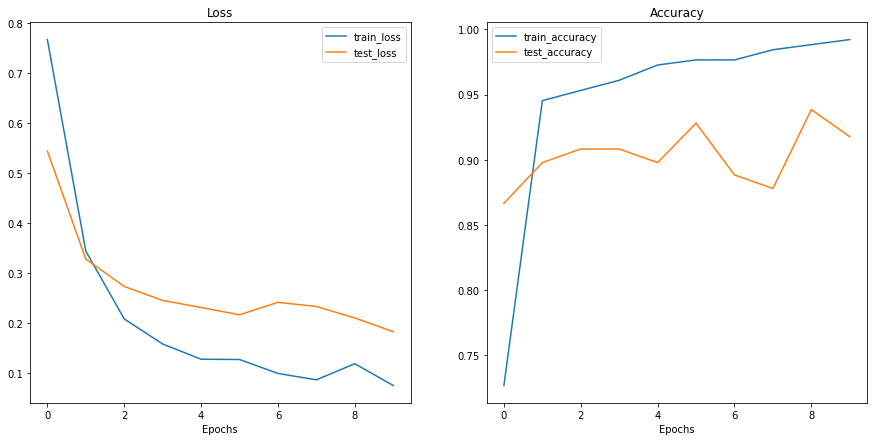

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_results)

### 10.6 Save our best performing ViT Model

Now we've got a model that performs quite well, how about we save it to file and then check it's filesize.

We want to check the filesize because if we wanted to deploy a model to say a website/mobile application, we may have limitation on the size of the model we can deploy.

E.g. a smaller model may be required due to compute restrictions.

In [ ]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="vit_b_16_feature_extractor_3.pth")

[INFO] Saving model to: models/vit_b_16_feature_extractor_3.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes and then convert into megabytes
pretrained_vit_model_size = Path("models/vit_b_16_feature_extractor_3.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


Our pretrained ViT gets some of the best results we've seen so far on our FoodVision Mini problem,. However, the mosel size is ~11x larger thna our next best performing model.

Perhaps the large model size might cause issues when we got to deplot it (e.g. hard to deploy such a large file/might not make predictions as fast as a smaller model).

## 11. Predicting on a custom image

[INFO] data/04-pizza-dad.jpeg already exists... skipping download


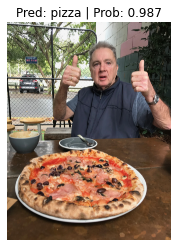

In [ ]:
# Download custom image 
import requests

from pathlib import Path
from going_modular.going_modular.predictions import pred_and_plot_image

custom_image_path = Path("data/04-pizza-dad.jpeg")

if not custom_image_path.is_file():
  print(f"[INFO] {custom_image_path} doesn't exist... downloading image")
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/04-pizza-dad.jpeg")
    f.write(request.content)
else:
  print(f"[INFO] {custom_image_path} already exists... skipping download")

pred_and_plot_image(model=pretrained_vit,
                    class_names=class_names,
                    image_path=custom_image_path,
                    image_size=(224, 224),
                    transform=vit_transforms,
                    device=device)